# MAST API Exoplanet Demo

This is a demo to show how some of the basic MAST API services work with exoplanet data in MAST. Specifically, we show how to find and download Hubble and Kepler data for exoplanets.

Full API documentation is available here: https://mast.stsci.edu/api

Examples used here: https://mast.stsci.edu/api/v0/MashupAPITutorial.html

Astroquery documentation available here: https://astroquery.readthedocs.io/en/latest/mast/mast.html

In [3]:
### Set-up imports
import sys
import os
import time
import re
import json
 
from urllib.parse import quote as urlencode
from urllib.request import urlretrieve
import http.client as httplib

from astropy.table import Table
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [4]:
### This is the functions which actually sends requests to the MAST server. 
### You should not have to change this.

def mastQuery(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The Mashup request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content

In [5]:
### I am defining a custom function to convert the JSON responses to Astropy tables for nicer handling
### and display, not absolutely necessary.

def convert_json_to_astropy_table(json_data):
    mastDataTable = Table()

    for col,atype in [(x['name'],x['type']) for x in json_data['fields']]:
        if atype=="string":
            atype="str"
        if atype=="boolean":
            atype="bool"
        mastDataTable[col] = np.array([x.get(col,None) for x in json_data['data']],dtype=atype)

    return mastDataTable

## 1. Getting Hubble Data through the API

In [6]:
### STEP 1: Given an object name, find its RA and Dec. Can skip if these are known.

# Choose target
objectOfInterest = 'WASP-19'

# Another good one is HAT-P-11, but no high level STIS products
# objectOfInterest = 'HAT-P-11'

# Formulate the request
resolverRequest = {'service':'Mast.Name.Lookup',
                     'params':{'input':objectOfInterest,
                               'format':'json'}, # specify format here, also possible: extjs, votable, csv
                     }

# Actually send the request
headers,resolvedObjectString = mastQuery(resolverRequest)

# Convert to JSON
resolvedObject = json.loads(resolvedObjectString)

pp.pprint(resolvedObject)

### Any returned parameter can be accessed as:
### resolvedObject['resolvedCoordinate']['ra']

{   'resolvedCoordinate': [   {   'cacheDate': 'Jan 23, 2017 12:31:32 PM',
                                  'cached': True,
                                  'canonicalName': 'GSC 08181-01711',
                                  'decl': -45.659183,
                                  'objectType': 'Star',
                                  'ra': 148.416988,
                                  'resolver': 'SIMBADCFA',
                                  'resolverTime': 118,
                                  'searchRadius': -1.0,
                                  'searchString': 'wasp-19'}],
    'status': ''}


In [7]:
### STEP 2: Do a cone search at the position of the object.
### This returns a list of all observations in MAST at this position. DOES NOT DOWNLOAD DATA.
### Setting radius to 0.0 will guarantee that only observations that contain the target
### in their footprints are returned

# Formulate request
mastRequest = {'service':'Mast.Caom.Cone',
               'params':{'ra':resolvedObject['resolvedCoordinate'][0]['ra'], ### using the ra returned above
                         'dec':resolvedObject['resolvedCoordinate'][0]['decl'], ### using the dec returned above
                         'radius':0.0},
               'format':'json',
               'pagesize':2000,
               'page':1,
               'removenullcolumns':True,
               'removecache':True}

# Actually send the request
headers,mastDataString = mastQuery(mastRequest)

# Convert to JSON
mastData = json.loads(mastDataString)

print("Query status:",mastData['status'])

Query status: COMPLETE


In [8]:
### Convert response to Astropy table
mastDataTable = convert_json_to_astropy_table(mastData)

### Show first 10 rows:
#print(mastDataTable[:10])

### Show the column headings:
#print(mastDataTable.colnames)

### Print the table if you want to see it:
#print(mastDataTable)

u_inst = np.unique(mastDataTable['instrument_name'])
print('There are {} unique instruments: {}'.format(len(u_inst), u_inst.data))

There are 2 unique instruments: ['STIS/CCD' 'WFC3/IR']


In [9]:
### Create 2 new tables, one for each instrument
wfc3_data = mastDataTable[mastDataTable['instrument_name'] == 'WFC3/IR']

print('WFC3 filters: {}'.format(np.unique(wfc3_data['filters']).data))

stis_data = mastDataTable[mastDataTable['instrument_name'] == 'STIS/CCD']

print('STIS filters: {}'.format(np.unique(stis_data['filters']).data))

WFC3 filters: ['F139M' 'G141']
STIS filters: ['G430L' 'G750L' 'MIRVIS']


Next, we move beyond exploring what data is in the archive and into downloading the data and looking at it.

### 1a. WFC3 data

In [10]:
### STEP 3: Choose which observations you want to get.

### I am choosing one direct (F139M) and one grism (G141) observation for the example.
### "obsid" is the parameter that the search function needs

to_get = wfc3_data['obsid'][wfc3_data['filters'] == 'F139M'][0],wfc3_data['obsid'][wfc3_data['filters'] == 'G141'][0] 

### to see the obsids
print(to_get)

### you can request multiple observations at the same time, BUT
### the list of 'obsid' needs to be a single string with comma-separated values:
to_get = ','.join(to_get)
#print(to_get)


('2002901006', '2002973641')


In [11]:
### STEP 4: Get a list of all available files for each observation

### Construct request
productRequest = {'service':'Mast.Caom.Products',
                 'params':{'obsid':to_get},
                 'format':'json',
                 'pagesize':100,
                 'page':1}   

### Make the call
headers,obsProductsString = mastQuery(productRequest)

### Convert to JSON
obsProducts = json.loads(obsProductsString)

print("Number of data products:",len(obsProducts["data"]))

### Convert to astropy table if you want to sort values, etc.
# productRequestTable = convert_json_to_astropy_table(obsProducts)
# print(productRequestTable)
# print(productRequestTable.colnames)

Number of data products: 18


In [12]:
### STEP 5: download data

### If you are doing complete daa reduction, you may want all files
### But I just want to see the final data so I'll focus on the FLT files
### FLT files are the final outputs of the calwf3 pipeline

### Inentify all FlT files in the data products by the 'flt.fits' extension

getProdArr = [x for x in obsProducts['data'] if 'flt.fits' in x.get("productFilename",None)]

print('These are the files identified for download:')
for x in getProdArr:
    print(x['productFilename'])

These are the files identified for download:
ibh715zlq_flt.fits
icab01c5q_flt.fits


In [13]:
### Iterate over the files and download all of them
### This is all public data so no login in required

### You shouldn't have to change this one

### Files will be downloaded to the current directory

for row in getProdArr:     
    if "http" in row['dataURI']: # link is url, so can just download 
        urlretrieve(row['dataURI'], row['productFilename'])
    else: # link is uri, so need to go through direct download request
        server='mast.stsci.edu'
        conn = httplib.HTTPSConnection(server)
        conn.request("GET", "/api/v0/download/file/"+row['dataURI'].lstrip('mast:'))
        resp = conn.getresponse()
        fileContent = resp.read()
        with open(row['productFilename'],'wb') as FLE:
            FLE.write(fileContent)
        conn.close()

Maybe you have some data reduction and analysis code that can pick up from here. 
I am just going to show what the science arrays looks like.

In [14]:
ls *flt.fits

ibh715zlq_flt.fits  icab01c5q_flt.fits


In [15]:
### obri04020 is the STIS file. WFC3 observation files start with 'i'
file1 = fits.open('ibh715zlq_flt.fits'); ### the semicollon just supresses output
file2 = fits.open('icab01c5q_flt.fits');

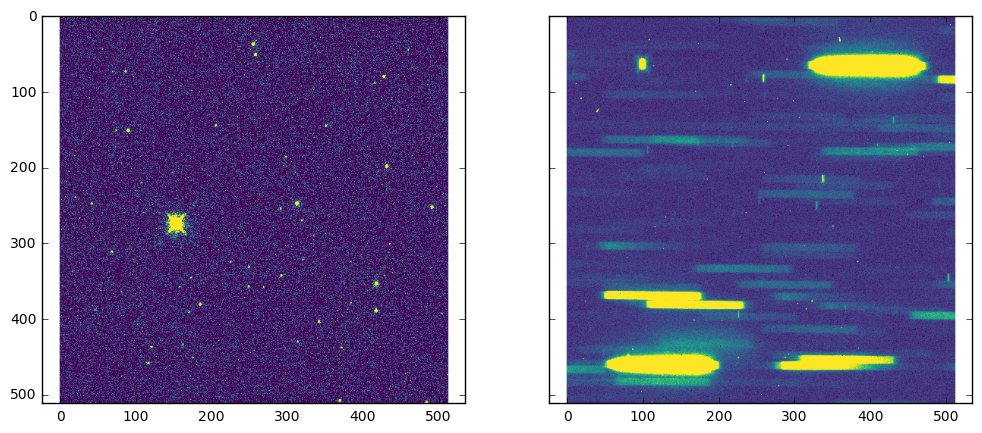

In [16]:
### Make a 2-panel plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)
ax1.imshow(file1['SCI'].data, cmap="viridis", clim=(0.0, 10.0))
ax2.imshow(file2['SCI'].data, cmap="viridis", clim=(5.0, 500.0))

### 1b. STIS data

In [41]:
to_get = stis_data['obsid'][10]
print(to_get) ### just one observation

2004008199


In [42]:
# Formulate request
productRequest = {'service':'Mast.Caom.Products',
                 'params':{'obsid':to_get},
                 'format':'json',
                 'pagesize':100,
                 'page':1}   

# Make request
headers,obsProductsString = mastQuery(productRequest)

# Load JSON
obsProducts = json.loads(obsProductsString)

print("Number of data products:",len(obsProducts["data"]))

productRequestTable = convert_json_to_astropy_table(obsProducts)
print(productRequestTable['productFilename'])

Number of data products: 14
 productFilename  
------------------
obri04020_crj.fits
obri04020_jif.fits
obri04020_jit.fits
obri04020_jwf.fits
obri04020_jwt.fits
obri04020_spt.fits
obri04020_trl.fits
obri04020_wav.fits
obri04020_wsp.fits
obri04020_asn.fits
obri04020_raw.fits
obri04020_flt.fits
obri04020_sx1.fits
obri04020_sx2.fits


In [43]:
### Inentify all FLT, SX1 and SX2 files in the data products
### FLT are the flat-fielded spectra
### SX1 and SX2 are the 1D and 2D extracted spectra

getProdArr = [x for x in obsProducts['data'] if ('_sx' in x.get("productFilename",None) or '_flt.fits' in x.get("productFilename",None))]

In [44]:
### Iterate over the files and download all of them
### This is all public data so no login in required

for row in getProdArr:     
    if "http" in row['dataURI']: # link is url, so can just download 
        urlretrieve(row['dataURI'], row['productFilename'])
    else: # link is uri, so need to go through direct download request
        server='mast.stsci.edu'
        conn = httplib.HTTPSConnection(server)
        conn.request("GET", "/api/v0/download/file/"+row['dataURI'].lstrip('mast:'))
        resp = conn.getresponse()
        fileContent = resp.read()
        with open(row['productFilename'],'wb') as FLE:
            FLE.write(fileContent)
        conn.close()

In [45]:
ls *sx*fits*

obri03060_sx1.fits  obri03060_sx2.fits  obri04020_sx1.fits  obri04020_sx2.fits


In [46]:
sx1 = Table.read('obri04020_sx1.fits') ### this is not a quite a standard table format

sx2 = fits.open('obri04020_sx2.fits')

#print(sx2_tab.info())
#print(len(sx1_tab['WAVELENGTH'][0]))

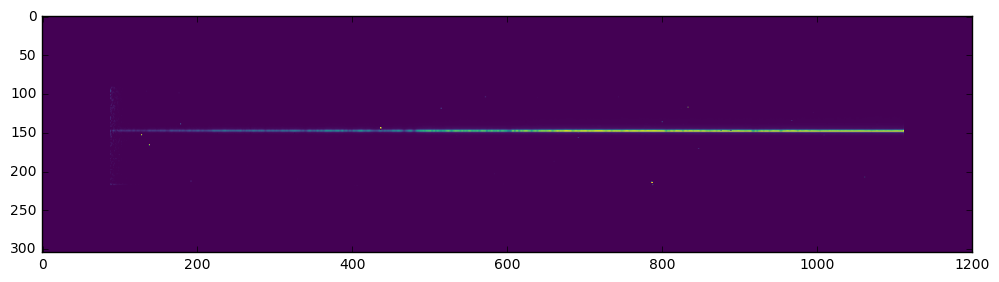

In [47]:
plt.figure(figsize=(12,10))
plt.imshow(sx2[1].data, cmap='viridis', clim=(0,1.4628e-13))

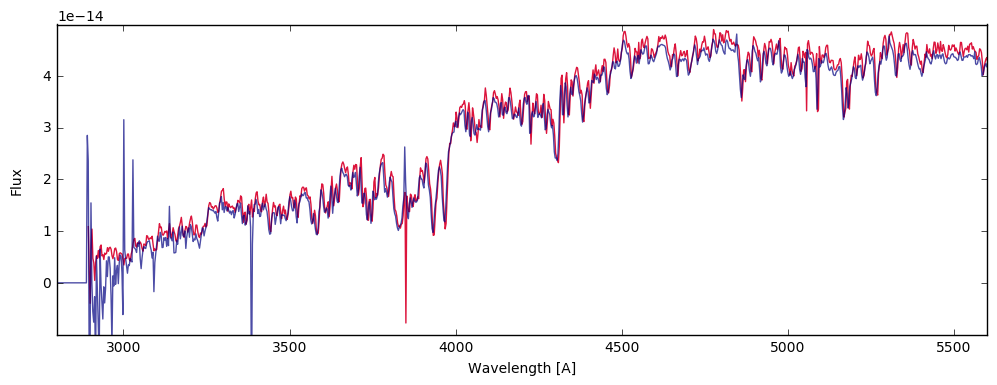

In [48]:
### Plot of the 1D spectrum

plt.figure(figsize=(12,4))

### Plot the 1D spectrum from the SX1 file
plt.plot(sx1['WAVELENGTH'][0], sx1['FLUX'][0], color='crimson')

### Create the wavelength array for the 2D spectrum using the header keywords
wave = sx2[1].header['CRVAL1'] + sx2[1].header['CD1_1']*(np.arange(np.shape(sx2[1].data)[1])-sx2[1].header['CRPIX1'])
### Plot the coadd across the dispersion direction from the 2D spectrum 
### Division by 10 is the flux-by-eye (not correct, just for the plot)
plt.plot(wave, np.sum(sx2[1].data, axis=0)/10, color='navy', alpha=0.7)

plt.xlim([2800.,5600.])
plt.ylim([-1e-14,5e-14])
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

## 2. Getting Kepler Data through the API

In [49]:
### STEP 1: Given an object name, find its RA and Dec. Can skip if these are known.

# Choose target
objectOfInterest = 'Kepler-12b'

# Formulate the request
resolverRequest = {'service':'Mast.Name.Lookup',
                     'params':{'input':objectOfInterest,
                               'format':'json'},
                     }
# Actually send the request
headers,resolvedObjectString = mastQuery(resolverRequest)

# Format JSON
resolvedObject = json.loads(resolvedObjectString)

pp.pprint(resolvedObject)

{   'resolvedCoordinate': [   {   'cacheDate': 'Jun 15, 2017 6:24:52 AM',
                                  'cached': True,
                                  'canonicalName': 'KOI-20.01',
                                  'decl': 50.040347,
                                  'objectType': 'Planet',
                                  'ra': 286.243446,
                                  'resolver': 'SIMBADCFA',
                                  'resolverTime': 116,
                                  'searchRadius': -1.0,
                                  'searchString': 'kepler-12b'}],
    'status': ''}


In [50]:
### STEP 2: Do a cone search at the position of the object.
### This returns a list of all observations in MAST at this position. DOES NOT DOWNLOAD DATA.
### Setting radius to 0.0 will guarantee that only observations that contain the target
### in their footprints are returned

# Formulate request
mastRequest = {'service':'Mast.Caom.Cone',
               'params':{'ra':resolvedObject['resolvedCoordinate'][0]['ra'],
                         'dec':resolvedObject['resolvedCoordinate'][0]['decl'],
                         'radius':0.0},
               'format':'json',
               'pagesize':2000,
               'page':1,
               'removenullcolumns':True,
               'removecache':True}

headers,mastDataString = mastQuery(mastRequest)

mastData = json.loads(mastDataString)

print(mastData.keys())
print("Query status:",mastData['status'])

dict_keys(['msg', 'paging', 'fields', 'data', 'status'])
Query status: COMPLETE


In [51]:
# Format as an astropy table
mastDataTable = convert_json_to_astropy_table(mastData)

### Show the column names
#print(mastDataTable.colnames)


In [52]:
print('Different types of observations: {}'.format(np.unique(mastDataTable['obs_collection']).data))

Different types of observations: ['Kepler' 'KeplerFFI']


In [53]:
### Split the output in 2 different tables: FFI and light curves
kepler_ffi_data = mastDataTable[mastDataTable['obs_collection'] == 'KeplerFFI']
kepler_data = mastDataTable[mastDataTable['obs_collection'] == 'Kepler']

In [54]:
print('Number of Kepler light curve datasets: {}'.format(len(kepler_data)))
print('Number of Kepler FFI datasets: {}'.format(len(kepler_ffi_data)))

Number of Kepler light curve datasets: 2
Number of Kepler FFI datasets: 39


Now lets grab a full frame image and some light curves.

In [55]:
### STEP 3: Choose which observations you want to get.

### One of each, the first one for simplicity, but you can use the parameters in the table to filter
### Doing them both at the same time
to_get = kepler_ffi_data['obsid'][0],kepler_data['obsid'][0] 
to_get = ','.join(to_get)

In [56]:
productRequest = {'service':'Mast.Caom.Products',
                 'params':{'obsid':to_get},
                 'format':'json',
                 'pagesize':100,
                 'page':1}   

headers,obsProductsString = mastQuery(productRequest)

obsProducts = json.loads(obsProductsString)

print("Number of data products:",len(obsProducts["data"]))
print("Product information column names:")
#pp.pprint(obsProducts)

productRequestTable = convert_json_to_astropy_table(obsProducts)

### OK, let's see what kinds of file types are available
print(productRequestTable['productFilename'])


Number of data products: 37
Product information column names:
              productFilename               
--------------------------------------------
                                        None
              kplr2009114174833_ffi-cal.fits
                                        None
kplr011804465-2013011073258_llc_bw_large.png
        kplr011804465-2009131105131_llc.fits
        kplr011804465-2009166043257_llc.fits
        kplr011804465-2009259160929_llc.fits
        kplr011804465-2009350155506_llc.fits
        kplr011804465-2010009091648_llc.fits
        kplr011804465-2010174085026_llc.fits
                                         ...
kplr011804465-2010355172524_lpd-targ.fits.gz
kplr011804465-2011177032512_lpd-targ.fits.gz
kplr011804465-2011271113734_lpd-targ.fits.gz
kplr011804465-2012004120508_lpd-targ.fits.gz
kplr011804465-2012179063303_lpd-targ.fits.gz
kplr011804465-2012277125453_lpd-targ.fits.gz
kplr011804465-2013011073258_lpd-targ.fits.gz
kplr011804465-2013131215648_lpd-targ.f

In [57]:
### STEP 4: Get a list of all available files the each observations

### Get the FFI image first, only one, these are ~400MB so relatively large
get_ffi_ProdArr = [x for x in obsProducts['data'] if 'ffi-cal.fits' in str(x.get("productFilename",None))]
print(get_ffi_ProdArr)

[{'productGroupDescription': 'Minimum Recommended Products', 'productFilename': 'kplr2009114174833_ffi-cal.fits', 'obs_id': 'kplr2009114174833_36', 'prvversion': None, 'obs_collection': 'KeplerFFI', '_selected_': None, 'productType': 'SCIENCE', 'productDocumentationURL': None, 'dataproduct_type': 'image', 'size': 407882880, 'description': 'Full Frame Image (FFI)', 'obsID': 4000000135, 'productSubGroupDescription': None, 'type': 'C', 'dataURI': 'http://archive.stsci.edu/missions/kepler/ffi/kplr2009114174833_ffi-cal.fits', 'project': 'Kepler'}]


In [58]:
### STEP 5: Download data

### THIS DOWNLOAD WILL TAKE A FEW TENS OF SECONDS!!!
### it might time out, restart

for row in get_ffi_ProdArr:     
    if "http" in row['dataURI']: # link is url, so can just download 
        urlretrieve(row['dataURI'], row['productFilename'])
    else: # link is uri, so need to go through direct download request
        server='mast.stsci.edu'
        conn = httplib.HTTPSConnection(server)
        conn.request("GET", "/api/v0/download/file/"+row['dataURI'].lstrip('mast:'))
        resp = conn.getresponse()
        fileContent = resp.read()
        with open(row['productFilename'],'wb') as FLE:
            FLE.write(fileContent)
        conn.close()

In [59]:
ls *ffi*

kplr2009114174833_ffi-cal.fits


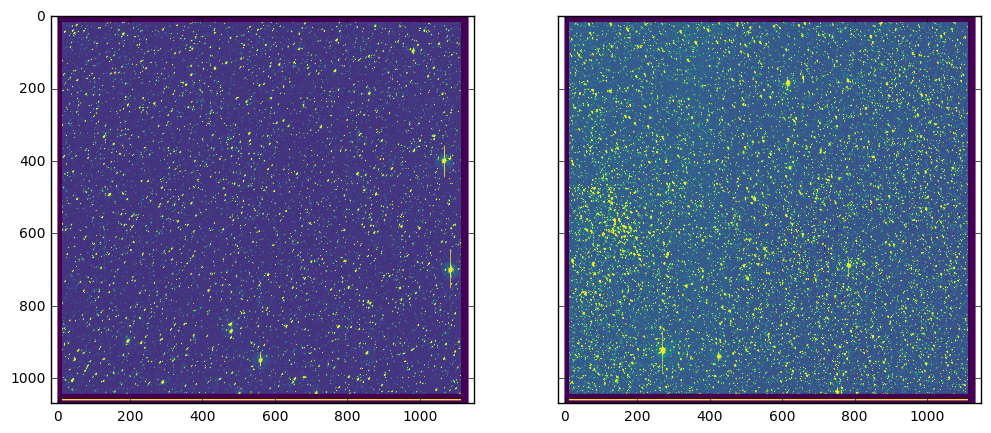

In [60]:
### What to these look like?
file = fits.open('kplr2009114174833_ffi-cal.fits')

### The following will give the structure of the file:
# print(file.info())

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)

### The first and the last detector
ax1.imshow(file[1].data, cmap='viridis', clim=(0,1000.))
ax2.imshow(file[84].data, cmap='viridis', clim=(0,1000.))

In [61]:
### Now get all the ligh curves

### STEP 4: Get a list of all available files for each observation

get_kepler_ProdArr = [x for x in obsProducts['data'] if '_llc.fits' in str(x.get("productFilename",None))]
#print(get_kepler_ProdArr)

In [62]:
### STEP 5: Download data

for row in get_kepler_ProdArr:     
    if "http" in row['dataURI']: # link is url, so can just download 
        urlretrieve(row['dataURI'], row['productFilename'])
    else: # link is uri, so need to go through direct download request
        server='mast.stsci.edu'
        conn = httplib.HTTPSConnection(server)
        conn.request("GET", "/api/v0/download/file/"+row['dataURI'].lstrip('mast:'))
        resp = conn.getresponse()
        fileContent = resp.read()
        with open(row['productFilename'],'wb') as FLE:
            FLE.write(fileContent)
        conn.close()

In [63]:
ls *llc*

kplr011804465-2009131105131_llc.fits  kplr011804465-2011177032512_llc.fits
kplr011804465-2009166043257_llc.fits  kplr011804465-2011271113734_llc.fits
kplr011804465-2009259160929_llc.fits  kplr011804465-2012004120508_llc.fits
kplr011804465-2009350155506_llc.fits  kplr011804465-2012179063303_llc.fits
kplr011804465-2010009091648_llc.fits  kplr011804465-2012277125453_llc.fits
kplr011804465-2010174085026_llc.fits  kplr011804465-2013011073258_llc.fits
kplr011804465-2010265121752_llc.fits  kplr011804465-2013131215648_llc.fits
kplr011804465-2010355172524_llc.fits


Filename: kplr011804465-2010174085026_llc.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      58   ()      
  1  LIGHTCURVE  BinTableHDU    161   4634R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE    ImageHDU        48   (6, 5)   int32   
None


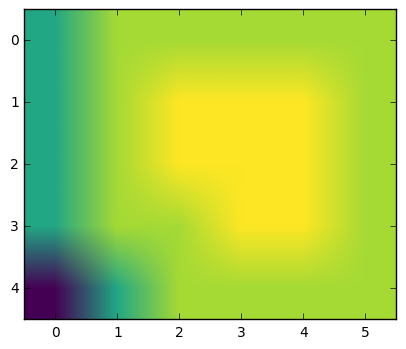

In [64]:
### The *llc* files are described here: http://archive.stsci.edu/kepler/manuals/archive_manual.pdf
### Here, again, you can plug your own analysis. I am just going to make some plots. 

### First show the aperture extension
file = fits.open('kplr011804465-2010174085026_llc.fits')
print(file.info())
plt.imshow(file[2].data, cmap='viridis',clim=(0.,15.))

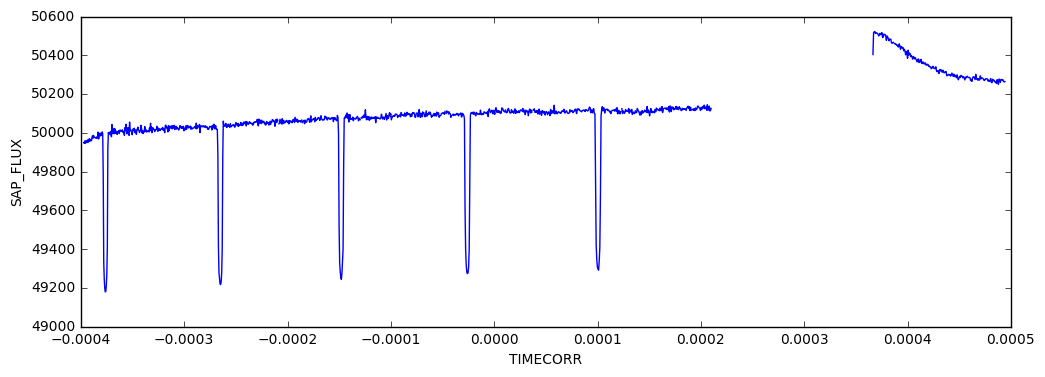

In [67]:
### Show the light curve


plt.figure(figsize=(12,4))

plt.plot(file[1].data['TIMECORR'], file[1].data['SAP_FLUX'])
plt.xlabel('TIMECORR')
plt.ylabel('SAP_FLUX')

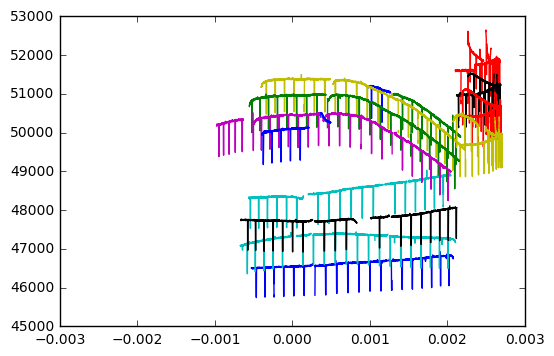

In [68]:
### Plot all the light curves

import glob
files = glob.glob('*_llc.fits')
for file in files:
    tab = Table.read(file);
    file = fits.open(file)
    plt.plot(tab['TIMECORR'], tab['SAP_FLUX'])
    plt.xlim([-0.003, 0.003])
    #plt.plot(tab['TIME']-tab['TIMECORR']+(0.25 + 0.62*(5-file[1].header['TIMSLICE']))/86400, tab['SAP_FLUX'])